<a href="https://colab.research.google.com/github/tXiao95/py_experiments/blob/master/CS584_LeCunMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 584: LeCun's MNIST Experiment

In this notebook, we aim to reproduce the experiment in LeCun's seminal paper.

In [0]:
import torch
import torch.nn as nn
# low level access to convolutions
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms

## Select a Device

To enable GPU support, go to Runtime -> Change runtime type


In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Create DataLoader

During the training, we need to access rando batches of example. In pytorch, this can be handled using the `DataLoader` object. To learn more about it, please see [the documentation](https://pytorch.org/docs/stable/data.html).

In [0]:
batch_size = 64;
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                      #  transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                      #  transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


## Visualize the First Batch

torch.Size([64, 1, 28, 28])
torch.Size([64])




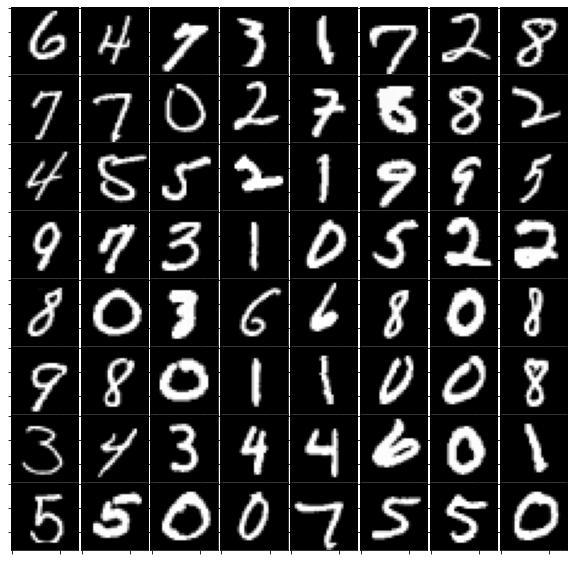

In [0]:
# get first batch
images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 
for i in range(images.shape[0]):
    ax1 = plt.subplot(gs1[i])
    plt.imshow(images[i,0,:,:],cmap='gray')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

## Create the Neural Network

In [0]:
class CNN():
  # input images are 28x28
  # layer 1: tanh, 5x5, convolution, 4 channels --> 4 x 24 x 24: weights K1,b1
  # layer 2: averaging --> 4 x 12 x 12
  # layer 3: tanh, 5x5, convolution, 12 channels --> 12 x 8 x 8: weights K2, b2
  # layer 4: averaging -> 12 x 4 x 4
  
  def __init__(self):
    self.K1 = torch.randn((4,1,5,5), requires_grad=True, device=device)
    self.b1 = torch.randn((4), requires_grad=True, device=device)
    self.K2 = torch.randn((12,4,5,5), requires_grad=True, device=device)
    self.b2 = torch.randn((12), requires_grad=True, device=device)

  def forward(self, x):
    # apply the first convolution layer
    # print(x.shape)
    x = F.tanh(F.conv2d(x,self.K1, bias=self.b1))
    # print(x.shape)
    # average pooling
    x = F.avg_pool2d(x,(2,2))
    # print(x.shape)
    # apply the second convolution
    x = F.tanh(F.conv2d(x,self.K2, bias=self.b2))
    # print(x.shape)
    # average pooling
    x = F.avg_pool2d(x,(2,2))
    # print(x.shape)
    return x
    


## Show the Output of the Network

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


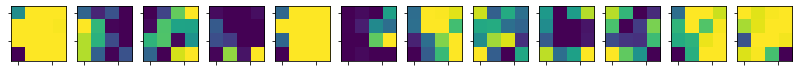

In [0]:
net = CNN()
Z   = net.forward(images.to(device))
plt.figure(figsize=(14,4))

for i in range(Z.shape[1]):
  ax = plt.subplot(1,Z.shape[1],i+1)
  plt.imshow(Z[0,i,:,:].cpu().detach().numpy())
  ax.set_xticklabels([])
  ax.set_yticklabels([])


## Create Loss Function

In [0]:
class softmaxLoss:
  # !! change required since Y will be n x nf in pytorch !!
  # multiply W from right, h(W) = exp(Y*W+b)/sum(exp(Y*W+b),1)

  def __init__(self, nf, nc):
    self.W = torch.randn((nf,nc), requires_grad=True, device=device)
    self.b = torch.randn((1,nc), requires_grad=True, device=device)

  def forward(self,Y,C):
    YW = torch.mm(Y,self.W) + self.b
    YW = YW - torch.max(YW,1,keepdim=True)[0]
    S  = torch.exp(YW)
    return -torch.sum(C * YW, (0,1)) + torch.sum(torch.log(torch.sum(S,1))) , S

nf = 12*16;
nc = 10;

loss = softmaxLoss(nf,nc)

Helper Functions

In [0]:
def getC(labels,nc):
  n = labels.shape[0]
  C = torch.zeros((n,nc),device=device)
  for k in range(n):    
    C[k,labels[k]] = 1
  return C

def evalLoss(train_loader):
  with torch.no_grad():
    ntotal = 0
    Ec = 0.0
    wrong = 0.0
    for  batch_idx,(images,labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      n = images.shape[0]
      Y = net.forward(images).reshape(n,-1)
      C  = getC(labels,nc)
      Eb, S = loss.forward(Y,C)
      Ec += Eb
      pred = torch.argmax(S,1)
      wrong += torch.sum(torch.sign(torch.abs(pred.view(-1)-labels.view(-1))))
      ntotal += n
    return Ec/ntotal, 100*(1-wrong/ntotal)

testLoss,testAccuracy = evalLoss(test_loader)
print(testLoss)
print(testAccuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(15.7945, device='cuda:0')
tensor(8.0900, device='cuda:0')


## Define Optimizer

In [0]:
optimizer = optim.SGD([net.K1,net.b1,net.K2,net.b2, loss.W,loss.b],lr=1.0)

## Train!

In [0]:
nEpochs = 20

for epoch in range(nEpochs):
    for batch_idx,(images,labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      # evaluate the loss , get gradient, and take a step
      optimizer.zero_grad()
      nb = images.shape[0]
      Y = net.forward(images).reshape(nb,-1)
      C = getC(labels,nc)
      trainLoss,S = loss.forward(Y,C)
      trainLoss.backward()
      optimizer.step()

    with torch.no_grad():
      # evaluate training loss after the full epoch
      Etrain,AccTrain   = evalLoss(train_loader)
      Etest,AccTest     = evalLoss(test_loader)
      print("epoch: %d\t training (loss: %1.4f\t accuracy: %1.2f%%), test (loss: %1.4f, accuracy: %1.2f%%)" % (epoch,Etrain,AccTrain,Etest,AccTest))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0	 training (loss: 3868.1287	 accuracy: 9.86%), test (loss: 3870.3447, accuracy: 9.58%)
epoch: 1	 training (loss: 5803.7505	 accuracy: 9.87%), test (loss: 5789.4839, accuracy: 9.80%)
